In [1]:
# Importing Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

#Upload the file using Anaconda : KaggleWord2VecUtility.py
from KaggleWord2VecUtility import KaggleWord2VecUtility

import pandas as pd
import numpy as np
import os
import time

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import re
import nltk

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [2]:
cd /Users/ram/Desktop/BagPopcorn

/Users/ram/Desktop/BagPopcorn


In [3]:
#Reading the Data
print os.getcwd()

# Function read_csv to read data, header =0 -> first line has column names, quoting = 3 -> ignore quotes
train = pd.read_csv('labeledTrainData.tsv', header=0, delimiter="\t", quoting=3)
#print train.shape()

test = pd.read_csv('testData.tsv', header=0, delimiter="\t", quoting=3 )
#print test.shape()

print "Column Values"
print train.columns.values

print 'The Tenth review is:'
print train["review"][9]

/Users/ram/Desktop/BagPopcorn
Column Values
['id' 'sentiment' 'review']
The Tenth review is:
"<br /><br />This movie is full of references. Like \"Mad Max II\", \"The wild one\" and many others. The ladybug´s face it´s a clear reference (or tribute) to Peter Lorre. This movie is a masterpiece. We´ll talk much more about in the future."


In [4]:
#Data Cleaning and Text Preprocessing

'''
#Using Beautiful Soup package, which is a Python library for pulling data out of HTML and XML files.
print "Tenth review after processing by Beautiful Soup"
example9 = BeautifulSoup(train["review"][9],"html.parser")
print example9.get_text()
print '-------------------------------------------------------------------------------------------'

#Using re package, which is a python package for dealing with regular expressions
letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                   # The pattern to replace it with
                      example9.get_text() )  # The text to search
print letters_only
print '-------------------------------------------------------------------------------------------'

#Using lower() and split() : Tokenization, to lower case and split them into individual words
#u refers to unicode string.
lower_case = letters_only.lower()        # Convert to lower case
words = lower_case.split()               # Split into words
print words
print '-------------------------------------------------------------------------------------------'

#Using nltk.corpus to remove stopwords such as 'a','is', 'this'....
words = [w for w in words if not w in stopwords.words("english")]
print words
print '-------------------------------------------------------------------------------------------'
'''

def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review,"html.parser").get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Tokenization : Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    words_M = [w for w in words if not w in stops]   
    #
    # 6. WordNetLemmatizer should better be used with POS tagging
    wl = nltk.WordNetLemmatizer()
    words_L = [wl.lemmatize(word) for word in words_M]
    # 7. PorterStemmer(), LancasterStemmer(), SnowballStemmer()
    # stemming can often create non-existent words, whereas lemmas are actual words.
    ps = nltk.PorterStemmer()
    words_S = [ps.stem(word) for word in words_L]
    # 8. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( words_S ))   

'''
print train["review"][9]
print '-------------------------------------------------------------------------------------------'
clean_review = review_to_words( train["review"][9] )
print clean_review
'''

# Get the number of reviews based on the dataframe column size
num_reviews = train["review"].size
print num_reviews

print '-------------------------------------------------------------------------------------------'
print "Cleaning and parsing the training set movie reviews...\n"
clean_train_reviews = []
for i in xrange( 0, num_reviews ):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%5000 == 0 ):
        print "Review %d of %d\n" % ( i+1, num_reviews )                                                                    
    clean_train_reviews.append( review_to_words( train["review"][i] ))

25000
-------------------------------------------------------------------------------------------
Cleaning and parsing the training set movie reviews...

Review 5000 of 25000

Review 10000 of 25000

Review 15000 of 25000

Review 20000 of 25000

Review 25000 of 25000



<type 'list'>


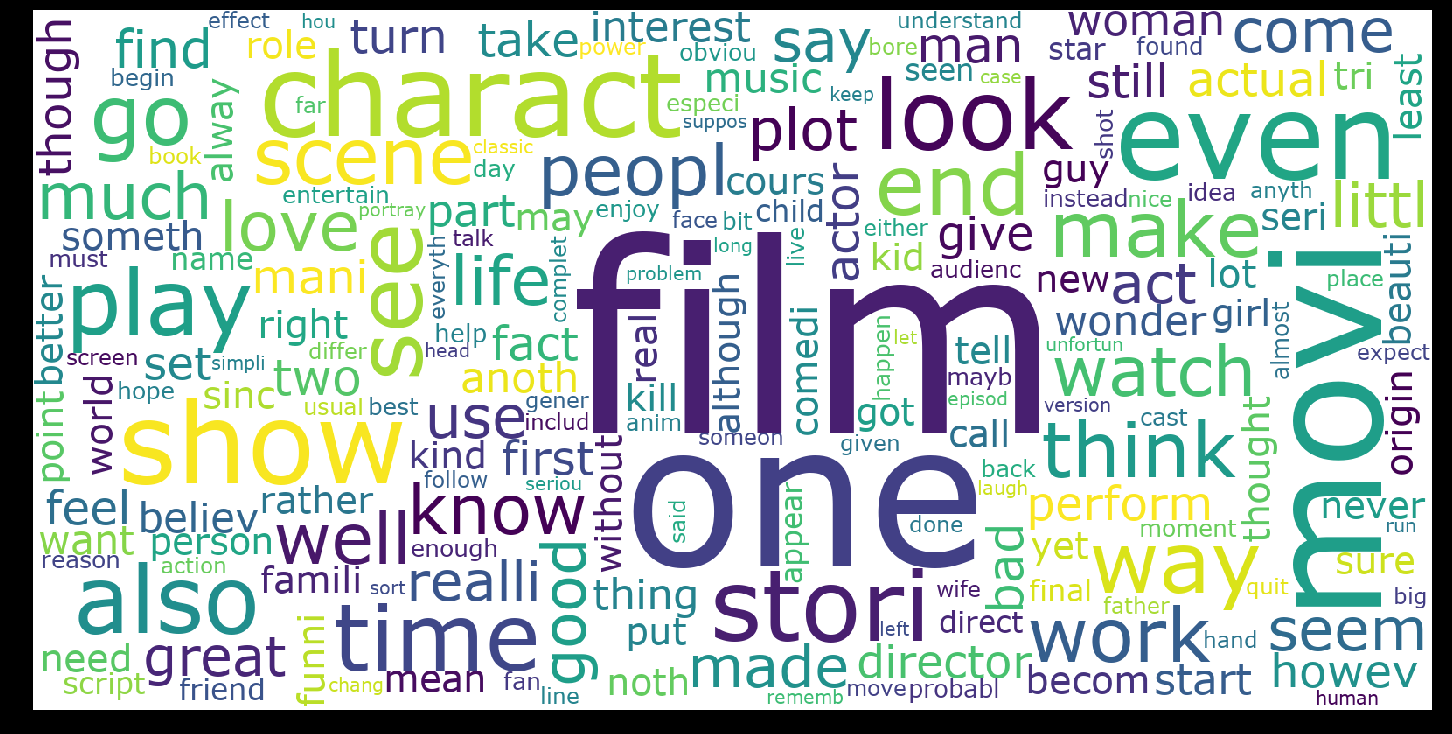

In [9]:
# Generating word cloud
print type(clean_train_reviews)
wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                      stopwords=STOPWORDS,
                      relative_scaling = 1.0,
                      background_color='white',
                      width=1600,
                      height=800
                     ).generate(''.join(clean_train_reviews))

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
#Creating Features from a Bag of Words (Using scikit-learn)

# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool. 
# The bag-of-words model is commonly used in methods of document classification where 
# the (frequency of) occurrence of each is used as a feature for training a classifier.

vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)
#print train_data_features

print '-------------------------------------------------------------------------------------------'
# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()
#print train_data_features

#Shape of train_data_features
print train_data_features.shape

#Sample data from train_date_features
#print train_data_features[0]
#print train_data_features[20]

#Printing the vocabulary
vocab = vectorizer.get_feature_names()
#print vocab

#Printing the count of each word in the vocabulary
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
'''
for tag, count in zip(vocab, dist):
    print count, tag
'''

In [ ]:
#Model Training and Fitting : XGBClassifier
start_time = time.time()
print ("Start Time-",start_time)

# Initialize the model
xgbc = XGBClassifier() 

# Fit the model
xgbf = xgbc.fit( train_data_features, train["sentiment"] )

elapsed_time = time.time() - start_time
print ("Elapsed Time-",elapsed_time)

In [ ]:
#Model Training and Fitting : Random Forest
start_time = time.time()
print ("Start Time-",start_time)

# Initialize the model
forest = RandomForestClassifier() 

# Fit the model
forestf = forest.fit( train_data_features, train["sentiment"] )

elapsed_time = time.time() - start_time
print ("Elapsed Time-",elapsed_time)

In [ ]:
#Creating Submission
# Read the test data
test = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=3 )

# Verify that there are 25,000 rows and 2 columns
print test.shape

# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
clean_test_reviews = [] 

print "Cleaning and parsing the test set movie reviews...\n"
for i in xrange(0,num_reviews):
    if( (i+1) % 5000 == 0 ):
        print "Review %d of %d\n" % (i+1, num_reviews)
    clean_review = review_to_words( test["review"][i] )
    clean_test_reviews.append( clean_review )

# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

# Use the XGB and RandomForest to make sentiment label predictions
result1 = xgbf.predict(test_data_features)
result2 = forestf.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output1 = pd.DataFrame( data={"id":test["id"], "sentiment":result1} )
output2 = pd.DataFrame( data={"id":test["id"], "sentiment":result2} )

# Use pandas to write the comma-separated output file
output1.to_csv( "Bag_of_Words_model1.csv", index=False, quoting=3 )
output2.to_csv( "Bag_of_Words_model2.csv", index=False, quoting=3 )

print 'End of Program'